In [1]:
!pip install dcor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.4 MB/s eta 0:00:00


In [2]:
import argparse
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency, spearmanr
import dcor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mutual_info_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
input_train = "lipinski_properties_train_new.csv"
input_baseline = "lipinski_properties_unconditional.csv"
input_gen = "lipinski_properties_lipinski.csv"
output_pairplot_train = "pairplot_train_new.png"
output_pariplot_unconditional = "pairplot_unconditional.png"
output_pariplot_gen = "pairplot_lipinski.png"
output_pca_unconditional = "pca_unconditional.png"
output_pca_gen = "pca_lipinski.png"
output_corr_comp_baseline_cont = "corr_comp_baseline_cont.png"
output_corr_comp_gen_cont = "corr_comp_gen_cont.png"
output_corr_comp_baseline_disc = "corr_comp_baseline_disc.png"
output_corr_comp_gen_disc = "corr_comp_gen_disc.png"

In [4]:
# Load the CSV file with Lipinski properties
df_train = pd.read_csv(input_train)
df_baseline = pd.read_csv(input_baseline)
df_gen = pd.read_csv(input_gen)

# Select only the Lipinski descriptors
lipinski_cols = ['MolWt', 'LogP', 'HBD', 'HBA']
train_data = df_train[lipinski_cols].astype(float).iloc[:5000]
gen_data = df_gen[lipinski_cols].astype(float).iloc[:5000]
baseline_data = df_baseline[lipinski_cols].astype(float).iloc[:5000]

# Scatterplots

In [ ]:
# Scatterplot matrix (pairplot)
g = sns.pairplot(train_data)
plt.suptitle('Lipinski Properties Scatterplot Matrix: Training Data', y=1.02)
g.figure.savefig(output_pairplot_train, dpi=300)
plt.show()

In [ ]:
# Scatterplot matrix (pairplot)
g = sns.pairplot(baseline_data)
plt.suptitle('Lipinski Properties Scatterplot Matrix: Unconditional Generation', y=1.02)
g.figure.savefig(output_pariplot_unconditional, dpi=300)
plt.show()

In [ ]:
# Scatterplot matrix (pairplot)
g = sns.pairplot(gen_data)
plt.suptitle('Lipinski Properties Scatterplot Matrix: LRO5 Guidance', y=1.02)
g.figure.savefig(output_pariplot_gen, dpi=300)
plt.show()

# Correlation (Continuous Variables)

In [ ]:
def compute_continuous_correlations(data):
    """
    Computes and prints Pearson, Spearman, Distance Correlation, and Information Gain
    between all pairs of columns in the input DataFrame (assumed to contain continuous data).

    Args:
        train_data (pd.DataFrame): Input DataFrame with numeric variables.
    """
    variables = data.columns.tolist()
    pearson_results = {}
    spearman_results = {}
    dcor_results = {}
    dcor_ttest_results = {}
    ig_results = {}

    for var1, var2 in itertools.combinations(variables, 2):
        x = data[var1].values
        y = data[var2].values

        # Pearson correlation
        pearson_corr, pearson_p = stats.pearsonr(x, y)
        pearson_results[(var1, var2)] = (pearson_corr, pearson_p)

        # Spearman correlation
        spearman_corr, spearman_p = stats.spearmanr(x, y)
        spearman_results[(var1, var2)] = (spearman_corr, spearman_p)

        # Distance correlation and significance test
        dc = dcor.distance_correlation(x, y)
        test = dcor.independence.distance_correlation_t_test(x, y)
        t_stat = test.statistic
        p_value = test.pvalue
        dcor_ttest_results[(var1, var2)] = (dc, t_stat, p_value)

        # Information Gain in both directions
        ig_xy = mutual_info_regression(x.reshape(-1, 1), y, random_state=0)[0]
        ig_yx = mutual_info_regression(y.reshape(-1, 1), x, random_state=0)[0]
        ig_results[(var1, var2)] = (ig_xy, ig_yx)

    # Print results

    print("\n### Pearson Correlation ###")
    for pair, (corr, pval) in pearson_results.items():
        print(f"{pair[0]} vs {pair[1]}: r = {corr:.3f}, p = {pval:.4f}")

    print("\n### Spearman Correlation ###")
    for pair, (corr, pval) in spearman_results.items():
        print(f"{pair[0]} vs {pair[1]}: rho = {corr:.3f}, p = {pval:.4f}")

    print("\n### Distance Correlation ###")
    for pair, (dc, t_stat, p_value) in dcor_ttest_results.items():
        print(f"{pair[0]} vs {pair[1]}: dCor = {dc:.3f}, T = {t_stat:.3f}, p = {p_value:.4f}")

    print("\n### Information Gain ###")
    for pair, (ig_xy, ig_yx) in ig_results.items():
        print(f"{pair[0]} → {pair[1]}: IG = {ig_xy:.3f}")
        print(f"{pair[1]} → {pair[0]}: IG = {ig_yx:.3f}")

    return spearman_results

In [ ]:
spearman_train = compute_continuous_correlations(train_data)

In [ ]:
spearman_baseline = compute_continuous_correlations(baseline_data)

In [ ]:
spearman_gen = compute_continuous_correlations(gen_data)

In [ ]:
thresholds = {
    'LogP': 5.0,
    'MolWt': 500.0,
    'HBD': 5.0,
    'HBA': 10.0
}

In [ ]:
def compute_binary_association_stats(data, thresholds):
    """
    Computes pairwise Chi-squared test, Yule's Q, and Information Gain
    for binarized variables based on specified thresholds.

    Args:
        data (pd.DataFrame): Input dataframe with numeric variables.
        thresholds (dict): Mapping of column name → threshold value.
    """
    binary_data = data.copy()
    for col, threshold in thresholds.items():
        if col in binary_data.columns:
            binary_data[col] = (binary_data[col] <= threshold).astype(int)

    variables = binary_data.columns.tolist()
    chi2_results = {}
    cramer_v_results = {}
    ig_results = {}

    for var1, var2 in itertools.combinations(variables, 2):
        x = binary_data[var1]
        y = binary_data[var2]

        table = pd.crosstab(x, y)
        assert table.shape == (2, 2), f"Contingency table for {var1} vs {var2} is not 2x2:\n{table}"

        # Chi-squared
        chi2, pval, _, _ = chi2_contingency(table)
        chi2_results[(var1, var2)] = (chi2, pval)

        # Cramér's V
        n = table.sum().sum()
        r, c = table.shape
        v = np.sqrt(chi2 / (n * (min(r - 1, c - 1))))
        cramer_v_results[(var1, var2)] = v

        # Mutual Information
        ig = mutual_info_score(x, y)
        ig_results[(var1, var2)] = ig

    # Optional: print results
    print("\n### Chi-Squared Test ###")
    for pair, (chi2, pval) in chi2_results.items():
        print(f"{pair[0]} vs {pair[1]}: χ² = {chi2:.3f}, p = {pval:.4f}")

    print("\n### Cramér's V ###")
    for pair, q in cramer_v_results.items():
        print(f"{pair[0]} vs {pair[1]}: Q = {q:.3f}")

    print("\n### Information Gain ###")
    for pair, ig in ig_results.items():
        print(f"{pair[0]} vs {pair[1]}: IG = {ig:.3f}")

    return cramer_v_results

In [ ]:
cramer_v_train = compute_binary_association_stats(train_data, thresholds)

In [ ]:
cramer_v_baseline = compute_binary_association_stats(baseline_data, thresholds)

In [ ]:
cramer_v_gen = compute_binary_association_stats(gen_data, thresholds)

In [ ]:
def compare_correlation_structures(corr_ref, corr_target, save_path,
                                   title="Association Comparison",
                                   xlabel="Reference", ylabel="Target",
                                   annotate=True):
    """
    Compare association structures between two dictionaries of values.

    Args:
        corr_ref (dict): Reference metric values. Format: {("Var1", "Var2"): value}
        corr_target (dict): Target metric values. Same format as corr_ref.
        title (str): Plot title.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        annotate (bool): Whether to annotate each point with its variable pair.
    """
    shared_keys = set(corr_ref.keys()) & set(corr_target.keys())
    if not shared_keys:
        raise ValueError("No common variable pairs to compare.")

    x = [corr_ref[pair] for pair in shared_keys]
    y = [corr_target[pair] for pair in shared_keys]

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.7)

    if annotate:
        for i, pair in enumerate(shared_keys):
            plt.text(x[i], y[i], f"{pair[0]}-{pair[1]}", fontsize=8, alpha=0.7)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
spearman_train_vals = {k: v[0] for k, v in spearman_train.items()}
spearman_baseline_vals = {k: v[0] for k, v in spearman_baseline.items()}

compare_correlation_structures(spearman_train_vals, spearman_baseline_vals,
                               output_corr_comp_baseline_cont,
                               title="Spearman Correlation Structure Comparison",
                               xlabel="Training", ylabel="Unconditional")

In [ ]:
spearman_gen_vals = {k: v[0] for k, v in spearman_gen.items()}
compare_correlation_structures(spearman_train_vals, spearman_gen_vals,
                               output_corr_comp_gen_cont,
                               title="Spearman Correlation Structure Comparison",
                               xlabel="Training", ylabel="LRO5")

In [ ]:
compare_correlation_structures(cramer_v_train, cramer_v_baseline,
                               output_corr_comp_baseline_disc,
                               title="Cramer's V Structure Comparison",
                               xlabel="Training", ylabel="Unconditional")

In [ ]:
compare_correlation_structures(cramer_v_train, cramer_v_gen,
                               output_corr_comp_gen_disc,
                               title="Cramer's V Structure Comparison",
                               xlabel="Training", ylabel="LRO5")

In [ ]:
def plot_correlation_heatmap(data, title, output_file):
    """
    Computes and plots a Spearman correlation heatmap.

    Args:
        data (pd.DataFrame): Input DataFrame.
        title (str): Title for the heatmap.
        output_file (str): Path to save the heatmap image.
    """
    correlation_matrix = data.corr(method='spearman')

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Plot heatmap for training data
output_heatmap_train = "heatmap_train.png" # Define output file name
plot_correlation_heatmap(train_data, '', output_heatmap_train)

In [ ]:
# Plot heatmap for baseline data
output_heatmap_baseline = "heatmap_baseline.png" # Define output file name
plot_correlation_heatmap(baseline_data, '', output_heatmap_baseline)

In [ ]:
# Plot heatmap for generated data
output_heatmap_gen = "heatmap_LRO5.png" # Define output file name
plot_correlation_heatmap(gen_data, '', output_heatmap_gen)

# Principal Component Analysis

In [5]:
thresholds = {
    'LogP': 5.0,
    'MolWt': 500.0,
    'HBD': 5.0,
    'HBA': 10.0
}

In [6]:
def stratified_binary_subsample(data, thresholds, n_samples=1000, random_state=42):
    # Binarize columns
    binary_data = data.copy()
    for col, threshold in thresholds.items():
        if col in binary_data.columns:
            binary_data[col] = (binary_data[col] <= threshold).astype(int)

    # Create binary pattern string (e.g., '1010') for stratification
    strat_labels = binary_data[list(thresholds.keys())].astype(str).agg(''.join, axis=1)

    # Keep only frequent patterns (at least 2 instances)
    pattern_counts = strat_labels.value_counts()
    valid_patterns = pattern_counts[pattern_counts >= 2].index
    valid_idx = strat_labels.isin(valid_patterns)

    filtered_data = data[valid_idx].copy()
    labels_filtered = strat_labels[valid_idx]

    # Stratified sampling
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=min(n_samples, len(filtered_data)), random_state=random_state)
    for _, idx in splitter.split(filtered_data, labels_filtered):
        return filtered_data.iloc[idx].copy()

In [7]:
train_data_sub = stratified_binary_subsample(train_data, thresholds)
baseline_data_sub = stratified_binary_subsample(baseline_data, thresholds)
gen_data_sub = stratified_binary_subsample(gen_data, thresholds)

In [8]:
def lipinski_flags(row):
    count = 0
    count += (row['MolWt'] <= 500)
    count += (row['LogP'] <= 5)
    count += (row['HBD'] <= 5)
    count += (row['HBA'] <= 10)
    return count

In [9]:
# Apply to both datasets
train_data_sub_num_rules = train_data_sub.apply(lipinski_flags, axis=1)
baseline_data_sub_num_rules = baseline_data_sub.apply(lipinski_flags, axis=1)
gen_data_sub_num_rules = gen_data_sub.apply(lipinski_flags, axis=1)

In [12]:
def plot_lipinski_pca(base_data, gen_data, base_num_rules, gen_num_rules, lipinski_cols, output_file, base_label, gen_label):
    """
    Perform PCA on Lipinski properties and plot projections for training and generated data.

    Args:
        base_data (pd.DataFrame): Baseline data.
        gen_data (pd.DataFrame): Generated data.
        base_num_rules (np.ndarray): Number of Lipinski rules satisfied (baseline).
        gen_num_rules (np.ndarray): Number of Lipinski rules satisfied (generated).
        lipinski_cols (list): Column names for Lipinski descriptors.
        output_file (str): Path to save the PCA plot.
        base_type (str): Label of baseline data.
        gen_type (str): Label of generated data.
    """
    # --- Standardize ---
    scaler = StandardScaler()
    base_scaled = scaler.fit_transform(base_data[lipinski_cols])
    gen_scaled = scaler.transform(gen_data[lipinski_cols])

    # --- PCA ---
    pca = PCA(n_components=2)
    base_pca = pca.fit_transform(base_scaled)
    gen_pca = pca.transform(gen_scaled)

    # --- Plot ---
    plt.figure(figsize=(8, 6))
    datasets = [
        (base_pca, base_num_rules, base_label, 'blue'),
        (gen_pca, gen_num_rules, gen_label, 'red')
    ]

    for data_pca, num_rules, label, color in datasets:
        plt.scatter(
            data_pca[num_rules >= 3, 0], data_pca[num_rules >= 3, 1],
            color=color, marker='o', label=f'{label} (≥3 rules)', alpha=0.5
        )
        plt.scatter(
            data_pca[num_rules < 3, 0], data_pca[num_rules < 3, 1],
            color=color, marker='x', label=f'{label} (<3 rules)', alpha=0.5
        )

    plt.xlabel("PC1", fontsize=16)
    plt.ylabel("PC2", fontsize=16)
    # plt.title("PCA on Lipinski properties")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(loc="upper right", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

    # --- Output loadings ---
    print("Explained variance ratio (train set):", pca.explained_variance_ratio_)
    pca_loadings = pd.DataFrame(pca.components_, columns=lipinski_cols, index=['PC1', 'PC2'])
    print("PCA components (loadings):")
    print(pca_loadings)

In [ ]:
def plot_conjunctive_pca(base_data, gen_data, base_num_rules, gen_num_rules, lipinski_cols, output_file, base_label, gen_label):
    """
    Perform PCA on Lipinski properties and plot projections for training and generated data.

    Args:
        base_data (pd.DataFrame): Baseline data.
        gen_data (pd.DataFrame): Generated data.
        base_num_rules (np.ndarray): Number of Lipinski rules satisfied (baseline).
        gen_num_rules (np.ndarray): Number of Lipinski rules satisfied (generated).
        lipinski_cols (list): Column names for Lipinski descriptors.
        output_file (str): Path to save the PCA plot.
        base_type (str): Label of baseline data.
        gen_type (str): Label of generated data.
    """
    # --- Standardize ---
    scaler = StandardScaler()
    base_scaled = scaler.fit_transform(base_data[lipinski_cols])
    gen_scaled = scaler.transform(gen_data[lipinski_cols])

    # --- PCA ---
    pca = PCA(n_components=2)
    base_pca = pca.fit_transform(base_scaled)
    gen_pca = pca.transform(gen_scaled)

    # --- Plot ---
    plt.figure(figsize=(8, 6))
    datasets = [
        (base_pca, base_num_rules, base_label, 'blue'),
        (gen_pca, gen_num_rules, gen_label, 'red')
    ]

    for data_pca, num_rules, label, color in datasets:
        plt.scatter(
            data_pca[num_rules == 4, 0], data_pca[num_rules == 4, 1],
            color=color, marker='o', label=f'{label} (=4 rules)', alpha=0.5
        )
        plt.scatter(
            data_pca[num_rules < 4, 0], data_pca[num_rules < 4, 1],
            color=color, marker='x', label=f'{label} (<4 rules)', alpha=0.5
        )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    # plt.title("PCA on Lipinski properties")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

    # --- Output loadings ---
    print("Explained variance ratio (train set):", pca.explained_variance_ratio_)
    pca_loadings = pd.DataFrame(pca.components_, columns=lipinski_cols, index=['PC1', 'PC2'])
    print("PCA components (loadings):")
    print(pca_loadings)

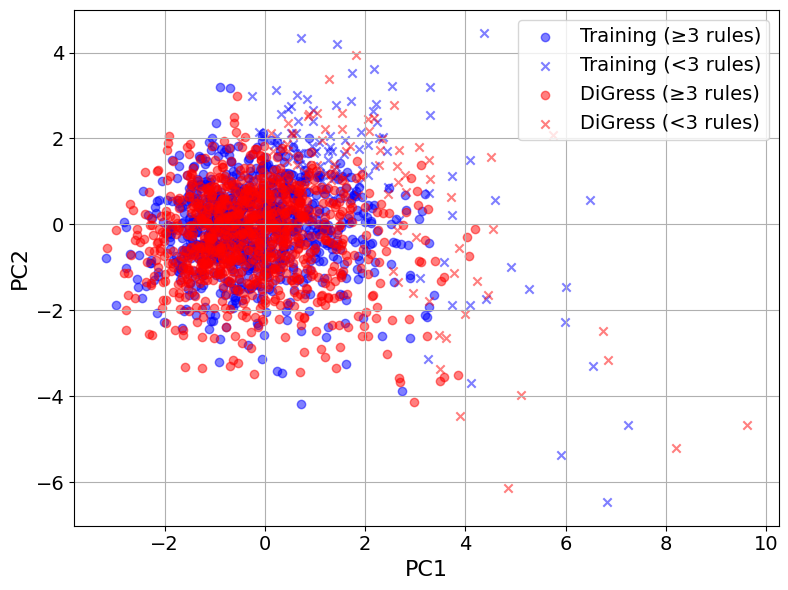

Explained variance ratio (train set): [0.46696081 0.33807381]
PCA components (loadings):
        MolWt      LogP       HBD       HBA
PC1  0.603471 -0.026184  0.504965  0.616561
PC2  0.428570  0.826574 -0.351940 -0.096129


In [13]:
plot_lipinski_pca(train_data_sub, baseline_data_sub, train_data_sub_num_rules, baseline_data_sub_num_rules, lipinski_cols, output_pca_unconditional, "Training", "DiGress")

In [ ]:
plot_lipinski_pca(baseline_data_sub, gen_data_sub, baseline_data_sub_num_rules, gen_data_sub_num_rules, lipinski_cols, output_pca_gen, "DiGress", "Lipinski's Rule")

In [ ]:
plot_conjunctive_pca(baseline_data_sub, gen_data_sub, baseline_data_sub_num_rules, gen_data_sub_num_rules, lipinski_cols, output_pca_gen, "DiGress", "Lipinki's Rule")